In [1]:
import logging
import os
import sys

os.environ["CPL_DEBUG"] = "ON"
logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

In [89]:
import memdem
import planetary_computer
import pystac_client
import rasterio
import rasterio.plot
import shapely
import shapely.geometry
import dask_geopandas

from rasterio.enums import TransformMethod


## Georeferenced SAR imagery (not projected)

Satellite imagery may not be projected to a coordinate reference system (CRS) but can still be georeferenced. This comes in the form of metadata associated with imagery that can be used to otherwise associate real world coordinates to pixel values in some way. The two primary methods of georeferencing are

- Ground control points (GCPs)
    - Collection of points mapping pixel coordinates to geographic/projected coordinates
    - Interpolate for uknown coordinate values
    - Most accurate near known GCPs, can be inconsistent for odd acquisition geometries
- Rational Polynomial Coefficients (RPCs)
    - Mathematical model mapping 3D (x, y, z) to 2D (row, column) coordinates based on sensor geometry
    - The inverse 2D (pixel) -> 3D (geographic) is implemented as an iterative solution by GDAL
    - only valid/accurate within the bounds of the scene/image
    - Additionally, depending on scene topography may require Digital Elevation Model (DEM) for accuracy

In [2]:
src = rasterio.open("zip://data/RS2_OK76385_PK678064_DK606753_F2N_20080419_142127_HH_HV_SLC.zip/RS2_OK76385_PK678064_DK606753_F2N_20080419_142127_HH_HV_SLC/product.xml")
print(f"GCP: {src.gcps[0][0]}")
print(f"Number of gcps: {len(src.gcps[0])}\n")
print(f"RPC: {src.rpcs}")

GCP: GroundControlPoint(row=0.5, col=0.5, x=-123.4809665720148, y=49.52809729106944, z=89.13533782958984, id='1', info='')
Number of gcps: 234

RPC: RPC(height_off=89.0, height_scale=701.0, lat_off=49.2199, lat_scale=0.3093, line_den_coeff=[1.0, 0.0009222511757408093, 0.0009437608823165506, 0.0, 3.227813186168402e-07, 0.0, -1.209023819818124e-08, 1.847595567040099e-06, 5.799102000140301e-07, -4.460833665210641e-07, 0.0, 0.0, -6.034797295293836e-08, 0.0, 1.667569505660956e-07, -2.974442475526043e-08, 0.0, 0.0, 0.0, 0.0], line_num_coeff=[0.002001303029283497, -0.1860717345625879, -1.127856422682348, -4.632230551975493e-05, 0.001019881908582774, 5.673855447822687e-08, -8.698433522294479e-08, -0.00322675985508854, -0.001332756784778704, 0.0, 1.215249975522747e-08, -7.132377372126199e-07, 2.017197679474549e-06, 8.275158167048898e-08, -1.210585983708413e-06, -1.07835388717073e-06, 5.032973521799926e-07, 0.0, 1.716128319528072e-08, 0.0], line_off=5760.0, line_scale=5761.0, long_off=-123.176, 

## Use georeferencing

In [3]:
src.xy(0, 0, transform_method=TransformMethod.gcps)

(-123.48089279215108, 49.52808523973891)

In [4]:
src.xy(0, 0, transform_method=TransformMethod.rpcs)

(-123.47959047080701, 49.52794990575094)

## Get image bounds using GCPs

Normally, would get bounds with `.bounds` property but this image isn't projected so we just get image dimensions

In [5]:
pixel_bounds = src.bounds
pixel_bounds

BoundingBox(left=0.0, bottom=11522.0, right=7449.0, top=0.0)

In [6]:
transformer = rasterio.transform.GCPTransformer(src.gcps[0])

POLYGON ((-122.30869640530985 49.3947632562547, -123.48089279215108 49.52808523973891, -123.56997799546143 49.183810069851056, -122.4059351016311 49.05051751246777, -122.30869640530985 49.3947632562547))


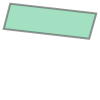

In [7]:
pixel_bounds_geom = shapely.geometry.Polygon.from_bounds(*pixel_bounds)
bounds_geom = shapely.ops.transform(transformer.xy, pixel_bounds_geom)
print(bounds_geom)
left, bottom, right, top = bounds_geom.bounds
bounds_geom

## Get image bounds using RPCs

### Generate DEM

In [78]:
demtiles = memdem.DEMTiles(bounds_geom.bounds, zoom=9)
with demtiles.open() as dem:
    with rasterio.transform.RPCTransformer(src.rpcs, rpc_dem=dem.name, rpc_dem_srs="EPSG:3857+5773") as transformer:
        print(transformer.xy(0, 0))
        geo_bounds_geom = shapely.ops.transform(transformer.xy, pixel_bounds_geom)

/home/ysebastien/.pyenv/versions/3.10.5/envs/rpc-demo/lib/python3.10/site-packages/memdem/vrt.py:53: RasterioDeprecationWarning: rasterio.parse_path will be removed in version 1.4.
  parsed_paths = [rasterio.parse_path(ds) for ds in urls]


(-123.48029452738264, 49.52802522834614)


POLYGON ((-122.31176243502217 49.39496638299336, -123.48029452738264 49.52802522834614, -123.56869387931494 49.183681922881284, -122.40430794335508 49.05017911900856, -122.31176243502217 49.39496638299336))


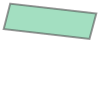

In [79]:
print(geo_bounds_geom)
geo_bounds_geom

## Interact with real data (Microsoft Building Footprints)

In [64]:
# ref: https://planetarycomputer.microsoft.com/dataset/ms-buildings#Example-Notebook
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
items = catalog.search(collections=['ms-buildings'], query={"msbuildings:region": {"eq": "Canada"}})
item = next(items.get_items())
asset = planetary_computer.sign(item.assets["data"])
asset


<Asset href=abfs://footprints/global/2022-06-14/ml-buildings.parquet/RegionName=Canada>

In [65]:
# ref: https://twitter.com/dkwiens/status/1520129589023940609
df = dask_geopandas.read_parquet(
    asset.href, 
    storage_options=asset.extra_fields["table:storage_options"],
    use_legacy_dataset=False,
    )

In [53]:
df

,geometry,RegionName
npartitions=24,,
,geometry,category[known]
,...,...
...,...,...
,...,...
,...,...


## Intersect with bounding box of our scene

In [66]:
vancouver_buildings = df[df.within(bounds_geom)].compute()

In [67]:
vancouver_buildings

,geometry,RegionName
45,"POLYGON ((-123.06076 49.22728, -123.06087 49.2...",Canada
53,"POLYGON ((-122.65402 49.21760, -122.65412 49.2...",Canada
93,"POLYGON ((-123.05720 49.23371, -123.05720 49.2...",Canada
100,"POLYGON ((-122.85239 49.12354, -122.85239 49.1...",Canada
104,"POLYGON ((-122.65805 49.20974, -122.65796 49.2...",Canada
...,...,...
59128,"POLYGON ((-122.39973 49.09150, -122.39974 49.0...",Canada
59130,"POLYGON ((-123.05316 49.26361, -123.05307 49.2...",Canada
59133,"POLYGON ((-123.16470 49.26941, -123.16487 49.2...",Canada
59137,"POLYGON ((-122.89140 49.15388, -122.89157 49.1...",Canada


### Subset 

In [9]:
coords = src.xy(src.height//2, src.width//2, transform_method=TransformMethod.gcps)
offset = 0.01
coords

(-123.18404813697387, 49.221306804241635)

In [86]:
mask = shapely.geometry.box(coords[0]-offset, coords[1]-offset/2, coords[0]+offset, coords[1]+offset/2)
subset = vancouver_buildings[vancouver_buildings.intersects(mask)]
subset

,geometry,RegionName
42351,"POLYGON ((-123.18362 49.21796, -123.18354 49.2...",Canada
66584,"POLYGON ((-123.18028 49.22320, -123.18066 49.2...",Canada
79529,"POLYGON ((-123.18147 49.21733, -123.18159 49.2...",Canada
101928,"POLYGON ((-123.17782 49.22224, -123.17800 49.2...",Canada
128847,"POLYGON ((-123.18047 49.21969, -123.18025 49.2...",Canada
...,...,...
49788,"POLYGON ((-123.17648 49.22108, -123.17647 49.2...",Canada
65193,"POLYGON ((-123.17955 49.22102, -123.17955 49.2...",Canada
96083,"POLYGON ((-123.17432 49.22427, -123.17422 49.2...",Canada
7551,"POLYGON ((-123.17508 49.21993, -123.17506 49.2...",Canada


In [74]:
subset.explore()

## Convert buildings from geographic to image coordinates

In [84]:
with demtiles.open() as dem:
    with rasterio.transform.RPCTransformer(
        src.rpcs, rpc_dem=dem.name, rpc_dem_srs="EPSG:3857+5773"
    ) as transformer:
        subset_pixel = subset.geometry.apply(
            lambda row: shapely.ops.transform(transformer.rowcol, row)
        )


/home/ysebastien/.pyenv/versions/3.10.5/envs/rpc-demo/lib/python3.10/site-packages/memdem/vrt.py:53: RasterioDeprecationWarning: rasterio.parse_path will be removed in version 1.4.
  parsed_paths = [rasterio.parse_path(ds) for ds in urls]


In [85]:
subset_pixel

42351     POLYGON ((5830.00000 3723.00000, 5828.00000 37...
66584     POLYGON ((5712.00000 3742.00000, 5713.00000 37...
79529     POLYGON ((5839.00000 3745.00000, 5841.00000 37...
101928    POLYGON ((5727.00000 3769.00000, 5727.00000 37...
128847    POLYGON ((5787.00000 3749.00000, 5786.00000 37...
                                ...                        
49788     POLYGON ((5748.00000 3785.00000, 5746.00000 37...
65193     POLYGON ((5756.00000 3755.00000, 5758.00000 37...
96083     POLYGON ((5676.00000 3797.00000, 5676.00000 37...
7551      POLYGON ((5769.00000 3801.00000, 5770.00000 38...
29754     POLYGON ((5670.00000 3636.00000, 5672.00000 36...
Name: geometry, Length: 273, dtype: geometry